In [21]:
# import necessary libraries
#pip install mtcnn
from mtcnn.mtcnn import MTCNN
import cv2
import os
import pandas as pd
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras_vggface import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import shutil

In [7]:
# Directory paths for the images
img_dir = './ML Final Project/BMI/Data/Images/'
test_dir = './ML Final Project/BMI/Data/Test Images/'
train_dir = './ML Final Project/BMI/Data/Train Images/'
img_processed_dir = './ML Final Project/BMI/Data/Processed Images/'

# Get a list of files in the image directory
image_files = os.listdir(img_dir)[:5]

# Print the first 5 file names
for file_name in image_files:
    print(file_name)

img_0.bmp
img_1.bmp
img_10.bmp
img_100.bmp
img_1000.bmp


In [8]:
# Read the image from the specified file path and convert the color space to RGB
image_path = img_dir + 'img_100.bmp'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Create an instance of the MTCNN detector
detector = MTCNN()

# Detect faces in the image using the MTCNN detector
detected_faces = detector.detect_faces(image)
print(detected_faces)

# Get the bounding box coordinates of the first detected face
first_face_box = detected_faces[0]['box']

1/1 [==============================] - 1s 665ms/step
[{'box': [59, 30, 151, 199], 'confidence': 0.9999477863311768, 'keypoints': {'left_eye': (98, 116), 'right_eye': (163, 106), 'nose': (130, 147), 'mouth_left': (101, 178), 'mouth_right': (173, 169)}}, {'box': [29, 136, 20, 27], 'confidence': 0.9912453293800354, 'keypoints': {'left_eye': (31, 147), 'right_eye': (38, 146), 'nose': (31, 152), 'mouth_left': (32, 158), 'mouth_right': (39, 157)}}]


In [18]:
# Crop the image based on the provided bounding box coordinates
def crop_image(image, x, y, w, h):
    cropped_image = image[y:(y+h), x:(x+w), :]
    return cropped_image

# Load the image and convert the color space from BGR to RGB
def detect_face(face_path):
    image = cv2.cvtColor(cv2.imread(face_path), cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image)
    
    if len(faces) > 0:
        box = faces[0]
        return box
    else:
        return None

# Load the image and convert it to an array
def detect_faces(face_path):    
    image = load_img(face_path)
    image = img_to_array(image)
    boxes = detector.detect_faces(image)
    return boxes

# Detect faces in the image and load the image as an array
def draw_box(face_path='img_4117.bmp', plot=True):
    boxes = detect_faces(face_path)
    im = np.array(Image.open(face_path), dtype=np.uint8)

    if plot:
        # Create figure and axes
        num_box = len(boxes)
        fig, ax = plt.subplots(1, (1 + num_box))
        fig.set_size_inches(4 * (1 + num_box), 4)
        
        # Display the image
        ax[0].imshow(im)
        ax[0].axis('off')
        
        # Create a Rectangle patch
        for idx, box in enumerate(boxes):
            box_x, box_y, box_w, box_h = box['box']
            rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
            ax[0].add_patch(rect)
            ax[0].text(box_x, box_y, '{:3.2f}'.format(box['confidence']))
            for i in box['keypoints'].keys():
                circle = patches.Circle(box['keypoints'][i], radius=5, color='red')
                ax[0].add_patch(circle)
             
            # Display the cropped face image
            ax[1 + idx].imshow(crop_image(im, *box['box']))
            ax[1 + idx].axis('off')
            
        plt.show()

    res = [crop_image(im, *box['box']) for box in boxes]

    return res

1/1 [==============================] - 1s 695ms/step


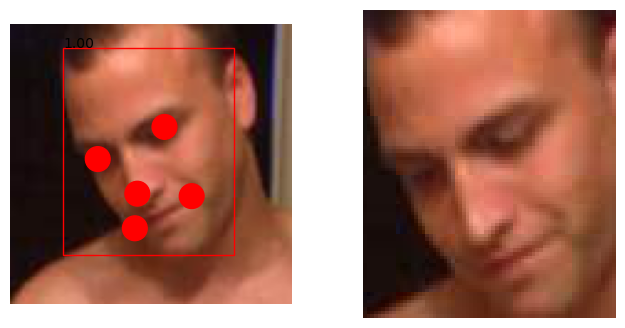

In [19]:
res = draw_box(img_dir + 'img_4117.bmp')

1/1 [==============================] - 0s 121ms/step


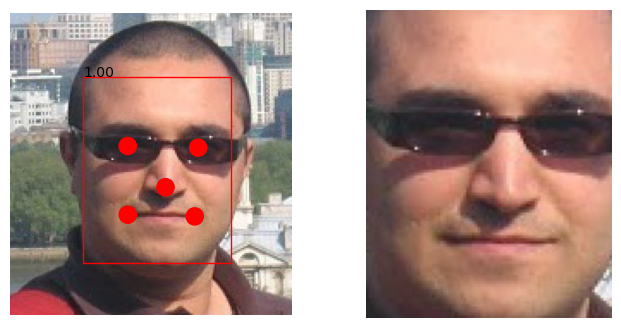

1/1 [==============================] - 0s 438ms/step


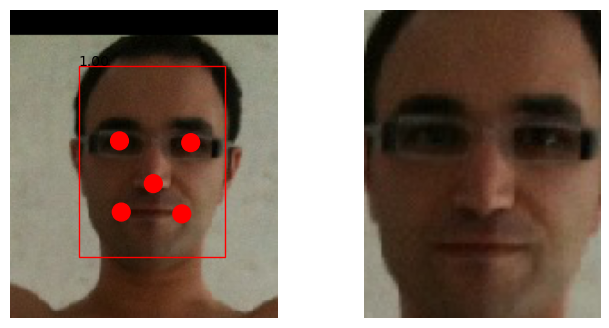

1/1 [==============================] - 0s 420ms/step


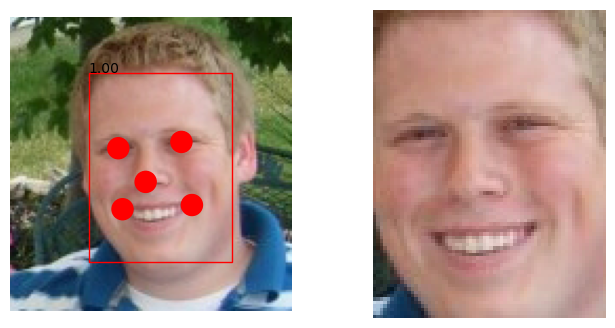

1/1 [==============================] - 0s 357ms/step


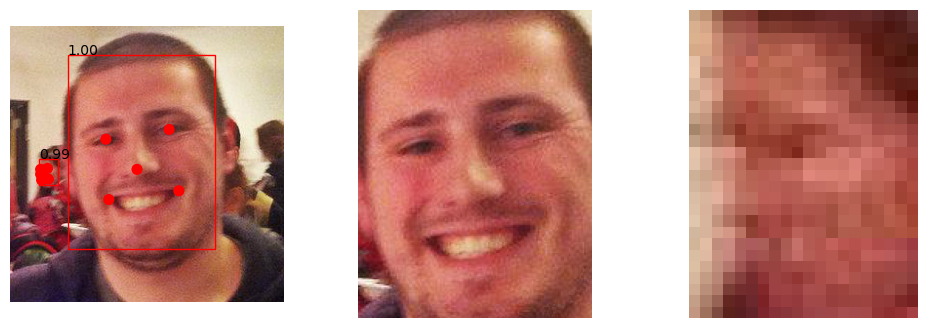

1/1 [==============================] - 0s 500ms/step


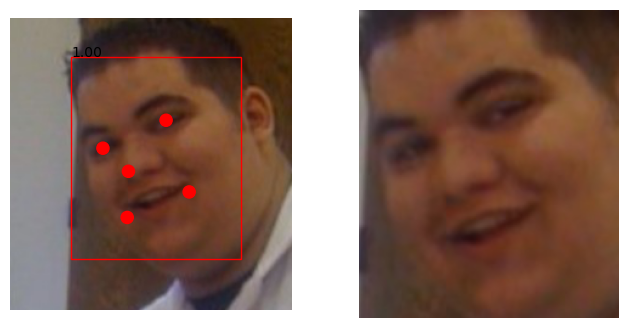

In [20]:
for img in os.listdir(img_dir)[:5]:
    draw_box(img_dir + img)

## Train/test Split

In [5]:
allimages = os.listdir('img_dir')

# load train and test data
train = pd.read_csv('./ML Final Project/BMI/Data/train.csv')
valid = pd.read_csv('./ML Final Project/BMI/Data/test.csv')

train = train.loc[(train['is_training'] == 1) & (train['name'].isin(allimages))]
valid = valid.loc[(valid['is_training'] == 0) & (valid['name'].isin(allimages))]

In [6]:
train_images = train['name']
train_images

0          img_0.bmp
1          img_1.bmp
2          img_2.bmp
3          img_3.bmp
6          img_6.bmp
            ...     
3361    img_3361.bmp
3362    img_3362.bmp
3363    img_3363.bmp
3364    img_3364.bmp
3365    img_3365.bmp
Name: name, Length: 3210, dtype: object

In [ ]:
test_images = valid['name']
test_images

In [ ]:
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

for img in test_images:
    shutil.copy2(img_dir + img, test_dir)

In [22]:
image_count = len(os.listdir(test_dir))
print("Number of images in train_dir:", image_count)

Number of images in train_dir: 752


In [9]:
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

for img in train_images:
    shutil.copy2(img_dir + img, train_dir)

In [10]:
image_count = len(os.listdir(train_dir))
print("Number of images in train_dir:", image_count)

Number of images in train_dir: 3210


## Preprocessing train images

In [14]:
def cut_negative_boundary(box):
    res = []
    for x in box['box']:
        if x < 0:
            x = 0
        res.append(x)
    box['box'] = res
    return box

In [ ]:
from tqdm import tqdm
import shutil

if os.path.exists(img_processed_dir):
    shutil.rmtree(img_processed_dir)
os.mkdir(img_processed_dir)

for img in train_images:
    try:
        box = detect_face(img_dir+img)
        box = cut_negative_boundary(box)
        im = plt.imread(img_dir+img)
        cropped = crop_img(im, *box['box'])
        plt.imsave(img_processed_dir+img, cropped)
    except:
        print(img)
        continue

1/1 [==============================] - 0s 32ms/step
img_59.bmp
1/1 [==============================] - 0s 24ms/step
img_77.bmp
1/1 [==============================] - 0s 26ms/step
img_134.bmp
1/1 [==============================] - 0s 24ms/step
img_148.bmp
1/1 [==============================] - 0s 27ms/step
img_168.bmp
1/1 [==============================] - 0s 30ms/step
img_169.bmp
1/1 [==============================] - 0s 20ms/step
